# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations

from fim_doe import *
from pyomo.contrib.sensitivity_toolbox.sens import sipopt

## Define Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_models import *

Three versions of this model is accomplished: 

Dynamic-DAE model: Temperature varying model discretized and integrated by Pyomo.DAE

Constant-DAE model: Temperature constant model discretized and integrated by Pyomo.DAE

Constant-analytical model: Temperature constant model discretized manually and using the analytical expressions for state variables.

In [3]:
# choose model from 'dynamic-DAE', 'constant-DAE', 'constant-analytical'
model_opt = 'dynamic-DAE'
#model_opt = 'constant-DAE'
#model_opt = 'constant-analytical'

if (model_opt=='dynamic-DAE'):
    createmod = create_model_dae
    disc = discretizer
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
elif (model_opt=='constant-DAE'):
    createmod = create_model_dae_const
    disc = discretizer
    t_control = [0]
    
elif (model_opt=='constant-analytical'):
    createmod = create_model_alge
    disc = None
    t_control = [0]

    
# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Define measurement time points
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

In [4]:
# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [6]:
# empty prior
prior_all = np.zeros((4,4))


# add prior information
#prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
#prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

#prior_all = prior_5_300_500


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]
Eigenvalue of the prior experiments FIM: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [8]:
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
#sensi_opt = 'sequential_kaug'

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

print('Design variable:', exp1)

Design variable: {'CA0': {0: 5}, 'T': {0: 570.21, 0.125: 300, 0.25: 300, 0.375: 300, 0.5: 300, 0.625: 300, 0.75: 300, 0.875: 300, 1: 300}}


In [9]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)


if_s = True
result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', scale_nominal_param_value=if_s, formula='central')


if sensi_opt == 'simultaneous_finite':
    result.extract_FIM(doe_object.m, doe_object.design_timeset,
                                                          doe_object.square_result, doe_object.obj_opt)
else: 
    result.calculate_FIM(doe_object.jac, doe_object.design_values)

Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2955
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      281

Total number of variables............................:      861
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       88
                     variab

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2955
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      281

Total number of variables............................:      861
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       88
                     variables with only upper bounds:        0
Total number of equality constraints.......

Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2955
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      281

Total number of variables............................:      861
                     variables with only lower bounds:      289
                variables with lower and upper bounds:       88
                     variables with only upper bounds:        0
Total number of equality constraints.......

In [10]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 2.787763562565366
D-optimality: 2.8197796747502895
E-optimality: -1.0122004288361668
Modified E-optimality: 3.7804340127346014


### Run sequential DOE automatically

This method runs a series of experiments in a row.

In [ ]:
# this only works for constant T mode. 
exp1 = generate_exp(t_control, 5, [300])
exp2 = generate_exp(t_control, 5, [500.92])
exp3 = generate_exp(t_control, 5, [528])
exp4 = generate_exp(t_control, 5, [546.8])
exp5 = generate_exp(t_control, 5, [562])

In [ ]:

exp_all = [exp1, exp2, exp3, exp4, exp5]


doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sequential_exp(exp_all, mode=sensi_opt, tee_option=True,
                                    scale_nominal_param_value=if_s, formula='central')

In [ ]:
print('=======Result summary=======')
for i in range(len(exp_all)):
    print('The ', i+1,'th experiment has optimality log10() values:')
    print('A-optimality:', np.log10(result[0][i].trace))
    print('D-optimality:', np.log10(result[0][i].det))
    print('E-optimality:', np.log10(result[0][i].min_eig))
    print('Modified E-optimality:', np.log10(result[0][i].cond))

## Optimization

In [11]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

square_result, optimize_result = doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, scale_nominal_param_value=True, objective_option='det', L_initial=None)


Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    24144
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1922

Total number of variables............................:     6406
                     variables with only lower bounds:     2316
                variables with lower and upper bounds:       88
                     variab

FIM: [[  17.66556334   18.74694576  -30.08229217  -76.6249341 ]
 [  18.74694576   30.76060367  -30.0321233  -124.73075662]
 [ -30.08229217  -30.0321233    52.037396    123.27864319]
 [ -76.6249341  -124.73075662  123.27864319  513.23289711]]
Trace: 613.696460122052
Determinant: 660.5392178909927
Condition number: 6041.624648957865
Minimal eigen value: 0.09711364246679273
Eigen values: [5.86724176e+02 2.64366622e+01 9.71136425e-02 4.38508241e-01]
Eigen vectors: [[ 0.14566483  0.44039769  0.86466461  0.19283862]
 [ 0.22710147 -0.06219395 -0.21781816  0.94716001]
 [-0.23618139 -0.85408186  0.45151616  0.1043824 ]
 [-0.93350149  0.26967751 -0.03230345  0.23410574]]
Model objective: 6.493056498309618
Objective(determinant) is: 660.5392179206082
Solution of  CA0  : [5]
Solution of  T  : [570.21, 300, 300, 300, 300, 300, 300, 300, 300]
======problem solver output======
converged
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


*********************************************************

======Result summary======
This optimization is solved with status: converged
It gives solution: {'CA0': [5.0], 'T': [477.13450463920645, 300.0, 300.00000049721297, 300.00000226167623, 300.00000640380813, 300.00001517876314, 300.0000313763859, 300.000065678056, 300.000207674314]}
The log10(OF) optimized is: 7.605877309503124
The result FIM is: [[  17.22555255   14.38327112  -36.46377844  -71.12350272]
 [  14.38327112   34.96951087  -27.34621792 -169.60206821]
 [ -36.46377844  -27.34621792   78.37663227  136.01315753]
 [ -71.12350272 -169.60206821  136.01315753  829.48817501]]


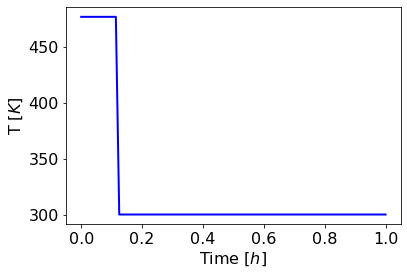

In [29]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('It gives solution:', optimize_result.solution)
print('The log10(OF) optimized is:', optimize_result.obj_value)
print('The result FIM is:', optimize_result.FIM)

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(value(optimize_result.model.T[i]))

si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
    
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

In [33]:
print(np.log10(0.12066184870855438))

-0.9184300249687846


## Grid search for 2 design variables

In [ ]:
#design_ranges = [list(np.linspace(1,5,9)), list(np.linspace(300,700,9))]
design_ranges = [list(np.linspace(300,700,9)), list(np.linspace(300, 700, 9))]

#dv_apply_name = ['CA0','T']
dv_apply_name = ['T']

#dv_apply_time = [[0],t_control]


# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

### 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

In [ ]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [ ]:

#design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )